In [1]:
# Fit Forward, 4 day gap

In [2]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [3]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [4]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [5]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [6]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [7]:
gap_length = 4

In [8]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    for ii in range(1, 8):
        jj = ii + gap_length - 1
        if len(primary_river.iloc[spoint-8:spoint]) != 8:
            print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
        if ii > 1:
            b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
            linear[ii-2] = b + m * jj
        if ii > 2:
            b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
            cubic[ii-3] = b + m * jj + c * jj**2
    if fittype == 'fit':
        useriver = matching_dictionary[river]
    elif fittype == 'backup':
        useriver = backup_dictionary[river]
    firstchoice = read_river(useriver, 'primary')
    for jj, length in enumerate(fitlength):
        for ii in range(length):
            denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
            if len(denom) == 1:
                ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                            firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
            else:
                bad = True
        if not bad:
            fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
    if bad:
        fittedbad = fittedbad + 1
    if doplots:
        ax.plot(persist)
        ax.plot(range(1, 7), linear)
        ax.plot(range(2, 7), cubic)
        if not bad:
            ax.plot(fitted)
        ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
        ax.plot(7, primary_river.iloc[spoint].values, 'x')
        ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
        ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad)

In [9]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [10]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [11]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [12]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, doplots)

    GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
    accumulateG += GG
    accumulateC += CC
    accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad

In [13]:
print (gap_length)

4


In [19]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  957.  957.  957.  957.] [ 77.38075562  79.28309966  80.32877961  81.31457474  81.77803916
  82.1041747   82.66501478 158.03755418 142.56863081 134.66654472
 131.47178594 128.67173906 124.73522751 450.85001084 371.13535188
 305.65583099 265.56261688 251.8151398   53.83722556  57.25385277
  61.59124673  65.63988265] [0.064      0.061      0.064      0.073      0.077      0.077
 0.074      0.245      0.236      0.219      0.213      0.205
 0.197      0.449      0.439      0.428      0.393      0.39
 0.03343783 0.03552769 0.03970742 0.04702194] [0.         0.         0.         0.         0.         0.
 0.         0.058      0.056      0.052      0.045      0.042
 0.042      0.188      0.192      0.169      0.168      0.173
 0.00208986 0.0031348  0.0031348  0.0031348 ]


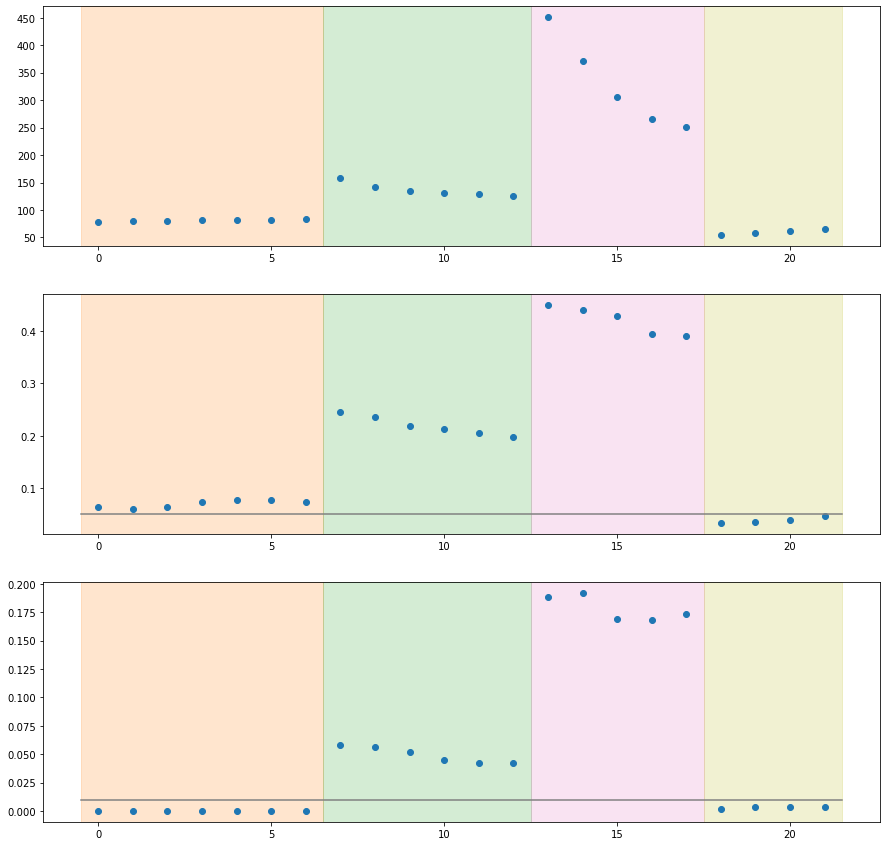

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [22]:
river = 'Salmon_Sayward'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  652.  652.  652.  652.] [ 40.76377032  41.96644856  41.93081656  42.19037453  42.68346658
  42.67169678  42.33088112 107.6575276   87.63995111  79.1184143
  76.81584872  74.30651039  70.15357114 393.80080638 267.08465883
 210.7244214  173.8863029  155.70836324  33.96695212  38.3534114
  37.67879376  37.87325859] [0.214      0.219      0.24       0.245      0.256      0.273
 0.273      0.471      0.464      0.468      0.46       0.48
 0.479      0.644      0.605      0.597      0.603      0.584
 0.10582822 0.12576687 0.1303681  0.13190184] [0.         0.         0.         0.         0.         0.
 0.         0.171      0.145      0.135      0.13       0.137
 0.131      0.285      0.266      0.255      0.232      0.237
 0.00153374 0.00153374 0.00153374 0.00153374]


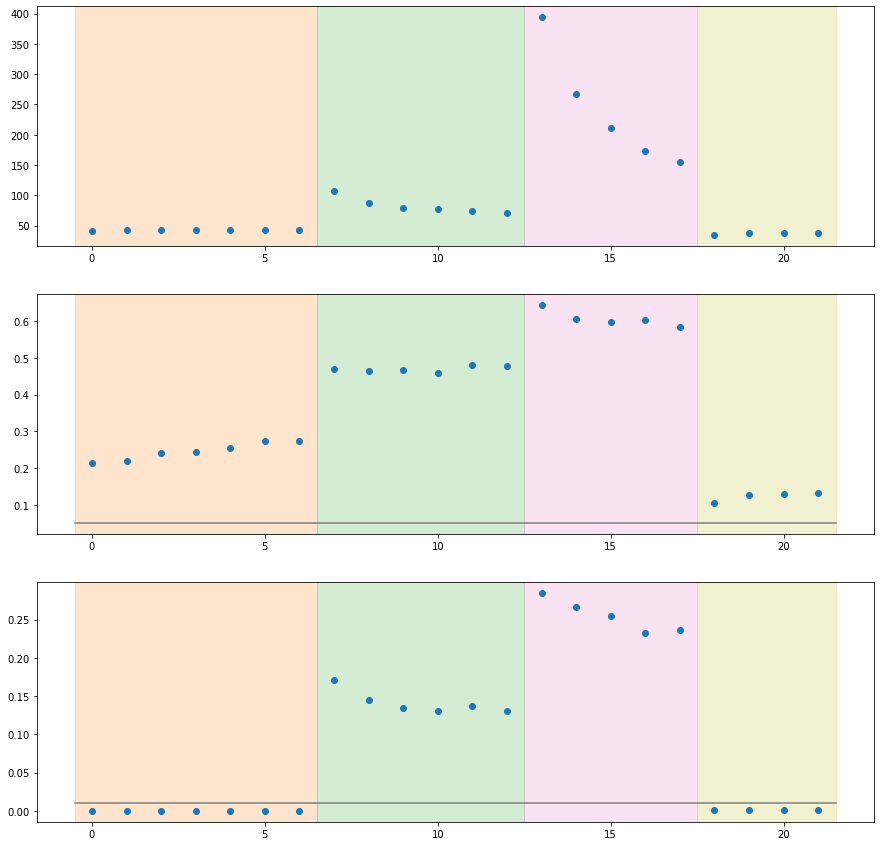

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [24]:
print (gap_length)

4


In [26]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  873.  873.  873.  873.] [ 77.60557842  79.56810948  80.98701251  81.6978461   81.84767831
  82.45479111  82.84044562 170.0340355  154.55269756 146.61737095
 141.74783087 135.97773674 130.53747672 515.4938924  428.765193
 358.27899509 311.6757879  282.31864103  46.32426701  49.37533186
  52.82698818  57.30357152] [0.119      0.124      0.12       0.122      0.121      0.136
 0.141      0.427      0.363      0.363      0.365      0.35
 0.338      0.665      0.619      0.611      0.587      0.57
 0.03436426 0.03436426 0.03436426 0.03550974] [0.    0.    0.    0.    0.    0.    0.    0.147 0.112 0.088 0.085 0.081
 0.081 0.3   0.276 0.275 0.26  0.229 0.    0.    0.    0.   ]


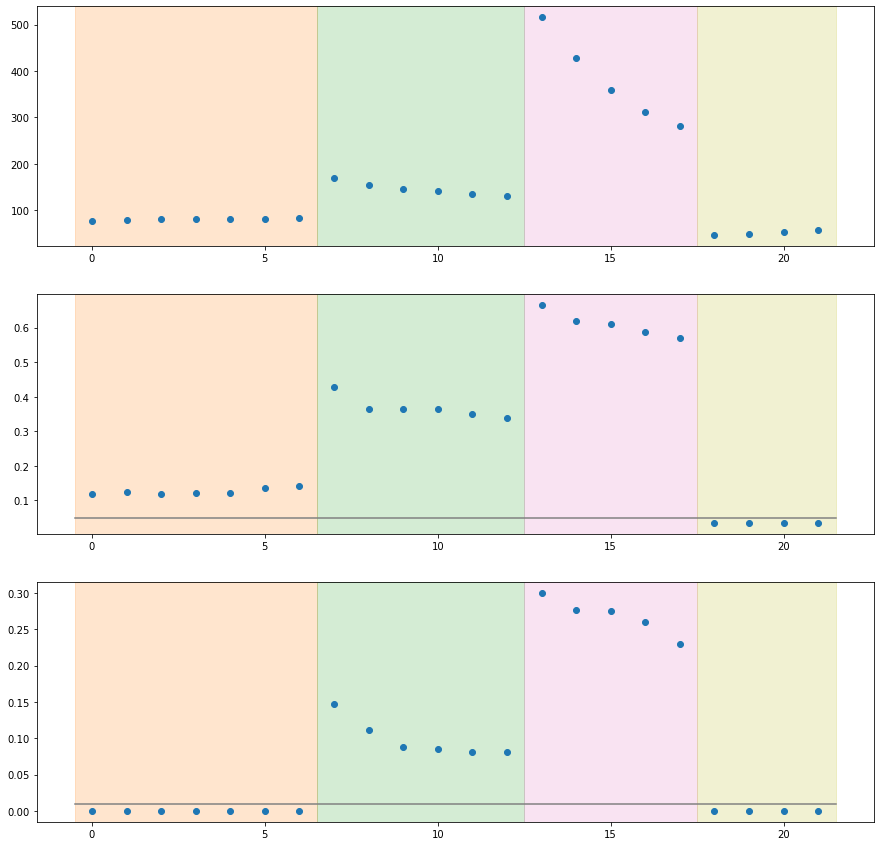

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [28]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [105.48546133 106.86038262 108.7171627  111.8697667  114.5023228
 115.80221467 117.3844214  231.48898335 216.09253032 197.19601521
 187.27905109 176.93845482 170.1561281  645.82095475 546.22020211
 474.02344999 435.46466257 395.4966964   60.40853594  64.21994037
  66.95350834  70.65607426] [0.115      0.123      0.133      0.137      0.146      0.139
 0.142      0.356      0.348      0.335      0.321      0.309
 0.284      0.516      0.514      0.497      0.495      0.506
 0.03603604 0.03203203 0.03403403 0.03703704] [0.    0.    0.    0.    0.    0.    0.    0.085 0.085 0.075 0.077 0.058
 0.063 0.231 0.222 0.205 0.206 0.216 0.    0.    0.    0.   ]


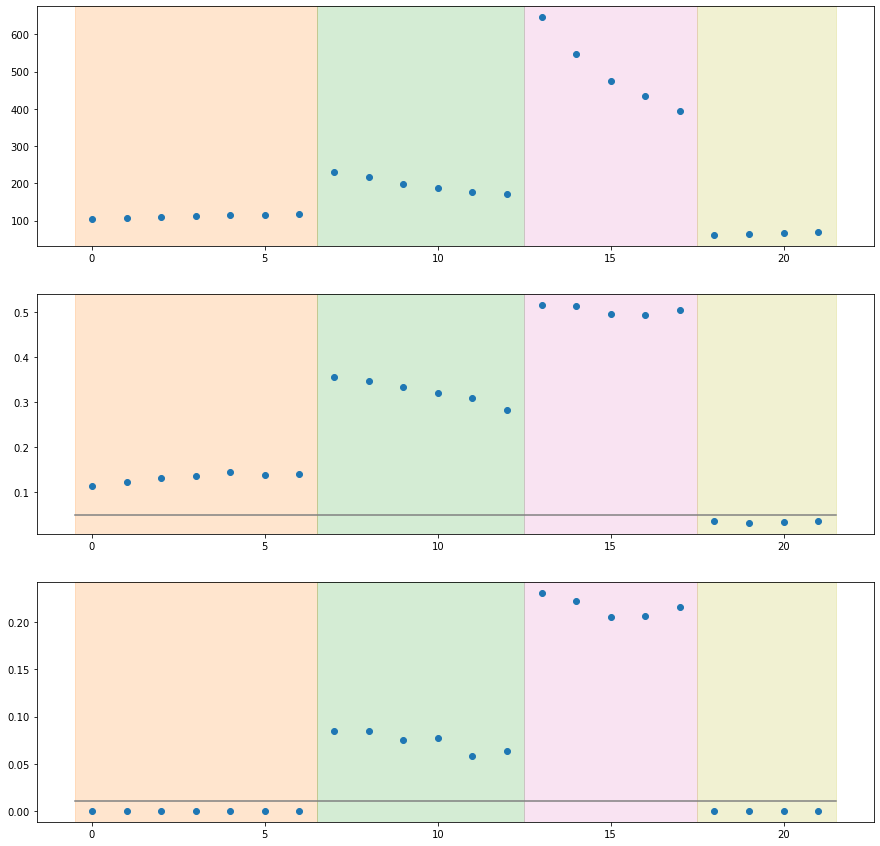

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [30]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  998.  998.  998.  998.] [120.1784735  120.2880641  121.92100163 123.86808963 125.05650484
 125.78596512 126.22343184 271.3635633  240.74343747 213.45846492
 192.26178098 184.65153788 178.18153739 805.8714663  631.38218802
 560.62005326 477.32023448 415.70285195 115.18686648 126.26846013
 132.81644725 141.28525129] [0.051      0.045      0.044      0.046      0.048      0.051
 0.049      0.244      0.219      0.193      0.164      0.158
 0.152      0.586      0.505      0.465      0.421      0.397
 0.03306613 0.04108216 0.04408818 0.0501002 ] [0.         0.         0.         0.         0.         0.
 0.         0.084      0.081      0.061      0.035      0.033
 0.027      0.283      0.242      0.232      0.204      0.201
 0.         0.00200401 0.         0.001002  ]


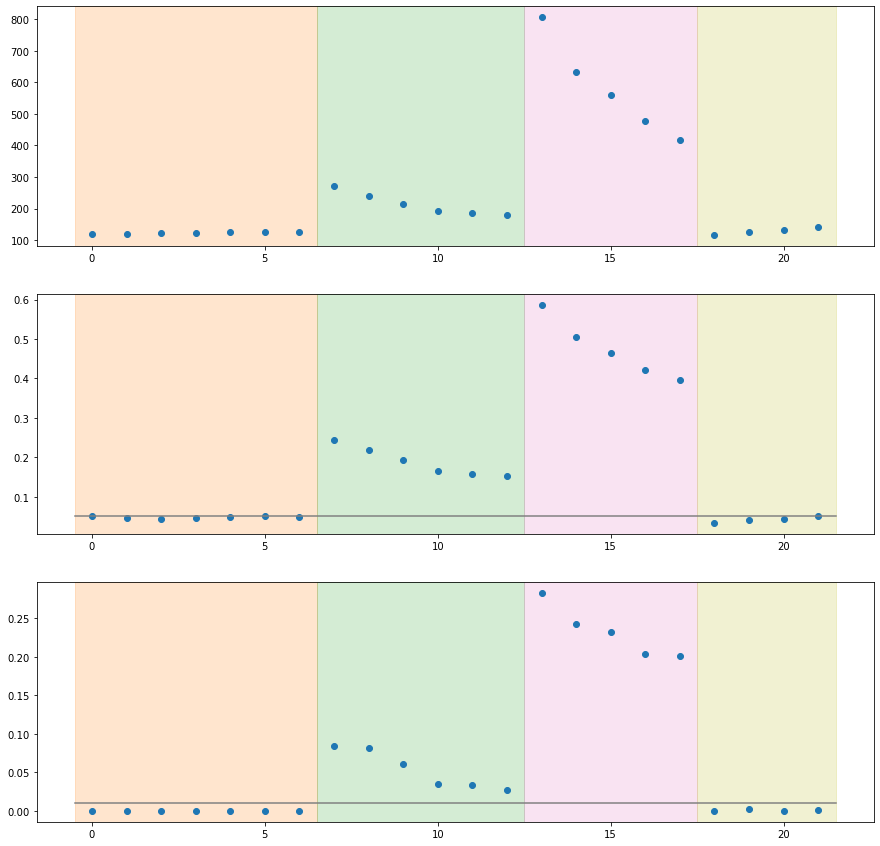

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [32]:
river = 'Nisqually_McKenna'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  997.  997.  997.  997.] [10.90884959 11.51201162 12.07472766 12.59403188 13.05363181 13.27653032
 13.47422211 21.70157157 20.98180083 19.96026126 19.64740224 18.92412208
 18.38268647 68.74868102 53.49576728 48.7566156  43.85999603 39.63153813
 14.24624194 15.26037688 15.86327084 16.43813513] [0.064      0.068      0.071      0.076      0.08       0.083
 0.093      0.181      0.164      0.176      0.174      0.17
 0.167      0.4        0.355      0.331      0.325      0.316
 0.09428285 0.111334   0.12437312 0.1444333 ] [0.    0.    0.    0.    0.    0.    0.    0.05  0.051 0.047 0.047 0.039
 0.038 0.168 0.15  0.134 0.129 0.123 0.    0.    0.    0.   ]


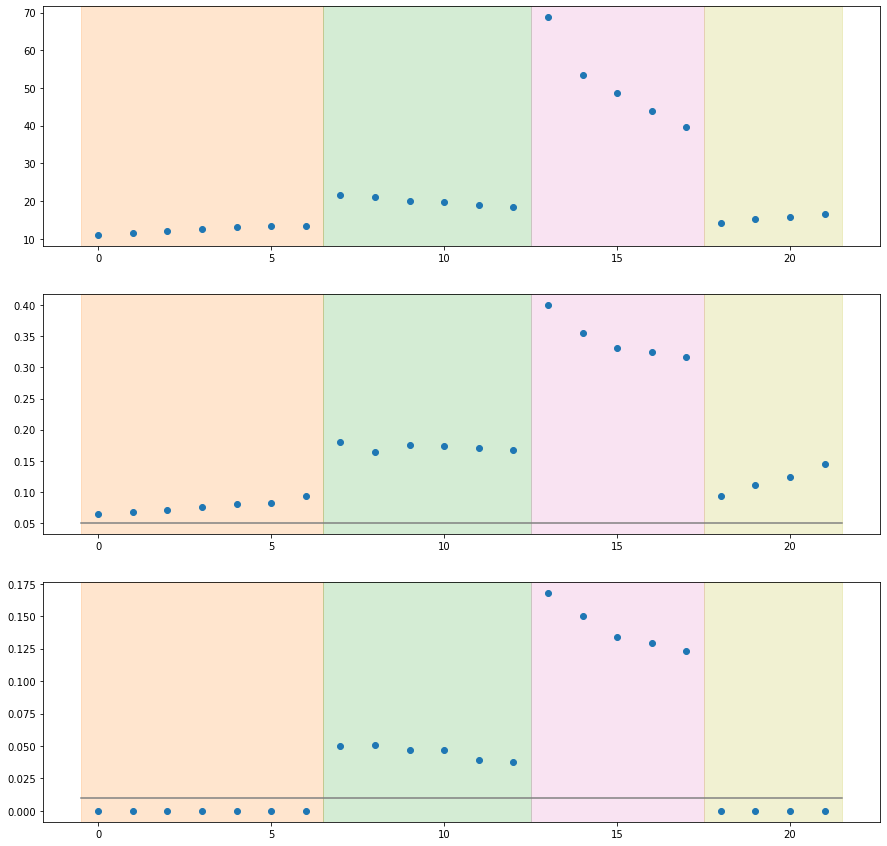

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [35]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [2.07249534 2.13103322 2.12747523 2.14008328 2.15848607 2.20821392
 2.23555232 3.319868   3.57237676 3.54462906 3.40274395 3.46971636
 3.32873008 9.40829425 7.39520364 7.36567952 6.95959937 6.39187849
 1.31083163 1.37861949 1.42212593 1.48225666] [0.065 0.066 0.068 0.075 0.082 0.081 0.084 0.148 0.158 0.146 0.154 0.158
 0.157 0.314 0.304 0.284 0.267 0.258 0.044 0.048 0.055 0.056] [0.    0.    0.    0.    0.    0.    0.    0.032 0.026 0.028 0.031 0.031
 0.028 0.13  0.109 0.102 0.109 0.1   0.004 0.004 0.003 0.003]


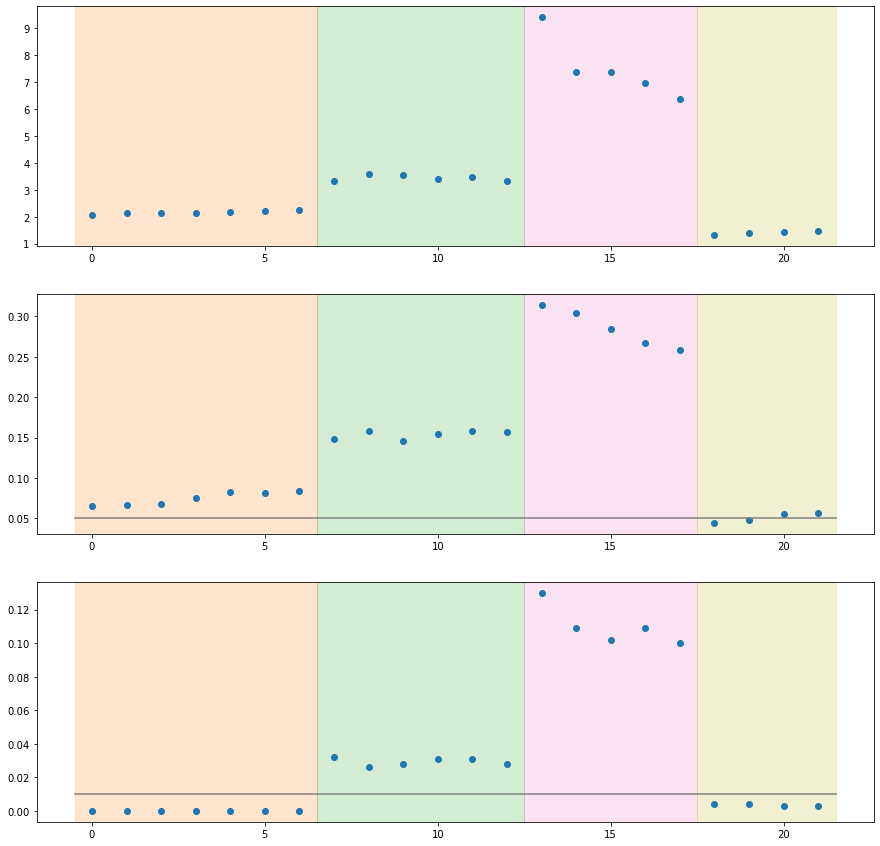

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [38]:
river = 'Clowhom_ClowhomLake'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  750.  750.  750.  750.] [ 8.25916476  8.25690178  8.24456291  8.26424739  8.22232454  8.15059154
  8.2218881  20.19041009 16.84403772 15.99217695 14.90738819 14.16480952
 14.07375672 67.15366714 47.06208537 38.6312202  34.53079542 31.30520835
  8.44125541 10.26682788 11.95777523 12.55534819] [0.224      0.234      0.24       0.241      0.246      0.258
 0.259      0.52       0.499      0.497      0.489      0.467
 0.474      0.654      0.644      0.639      0.623      0.627
 0.12       0.13733333 0.14933333 0.156     ] [0.         0.         0.         0.         0.         0.
 0.         0.195      0.171      0.147      0.157      0.138
 0.142      0.297      0.306      0.286      0.275      0.261
 0.00666667 0.01066667 0.01333333 0.01733333]


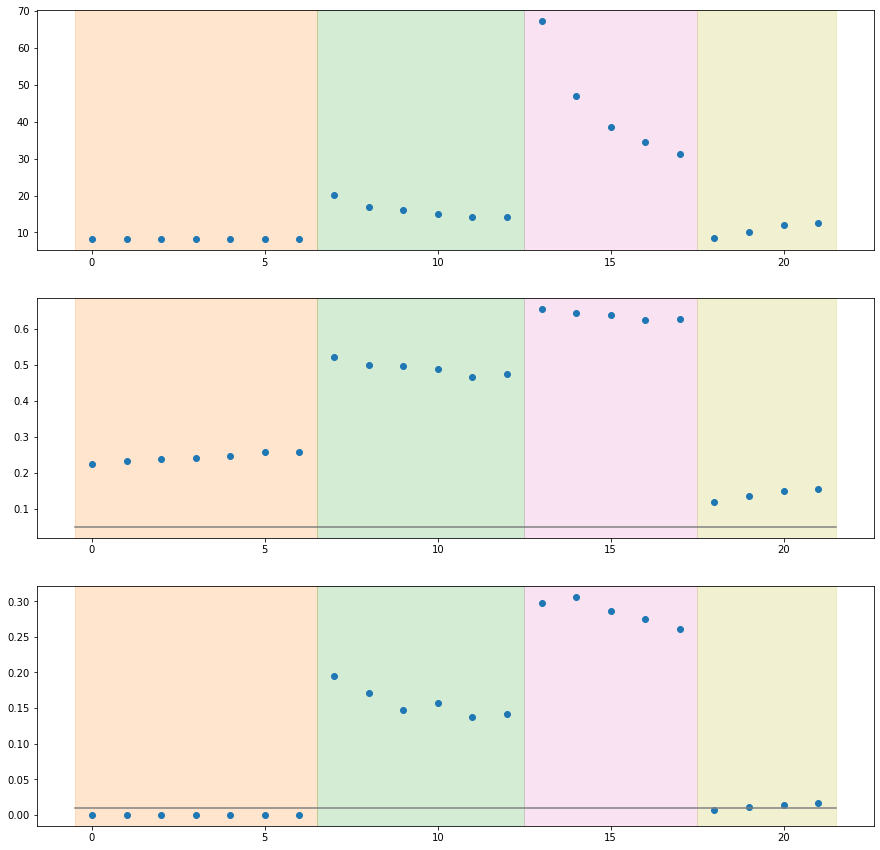

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');